# Yahoo Finance Overview

This notebook is primarily meant to act as a brief overview and quick visual reference for how to use the yahoo finance api. Unfortunately, this api isn't the most stable, so it's reasonably probable that this notebook will become outdated in the future if I do not keep updating it.  

This is the github link to the api's source repo, which may be useful if you need to get into the weeds of understanding how the api works (I've never had the need to do so myself): [Source Repo - yfinance](https://github.com/ranaroussi/yfinance)

In [2]:
# Import the necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import xlwings as xw
import yaml
import yfinance as yf
from typing import List, Dict, Tuple, Optional, Union, Callable, Any, Iterable

# ------------- Now, add a bunch of matplotlib settings and enhancements ----------
# Bunch of default matplotlib setups
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [14, 8]


from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    ''' Formats the y-axis labels as percentages. '''
    return f'{x:.1%}'

COLOR_SCHEME = [
        "#3f4c60",
        "#93c9f9",
        "#94045b",
        "#83889d",
        "#ffc000",
        "#386f98",
        "#9dabd3",
        "#b80571",
        "#45ad35",
        "#b38825",
        "#525e70",
        "#98bbdc",
        "#aa6597",
        "#6abd5d",
        "#716920",
    ]  
def set_mpl_colors() -> None:
    import matplotlib as mpl
    from cycler import cycler
    mpl.rcParams["axes.prop_cycle"] = cycler(color=COLOR_SCHEME)

set_mpl_colors()


# pd.set_option('display.float_format', lambda x: f'{x:,.4}')


## Useful Functions

In [3]:
def color_pos_neg(val):
    '''Format positive numbers in green and negative numbers in red. '''
    color = 'red' if val < 0 else 'green'
    return f'color: {color}'

def display_prettified_df(df: pd.DataFrame) -> None:
    '''Display a dataframe with some nice formatting. '''
    # Copy so that we can modify the dataframe without affecting the original
    df_display = df.copy()

    # Convert the index to strings
    df_display.index = df_display.index.strftime('%Y-%m-%d')

    # Format the numbers
    df_display = df_display.style.format("{:.2%}")

    # Apply the color formatting
    df_display = df_display.applymap(color_pos_neg)

    return df_display

## Price & Returns
The most basic and recurrent task one uses the yfinance api for is downloading price data, typically with the goal of calculating returns. So let's see it in action. 

In [17]:
# Specify the tickers we want to download
TICKERS = ['AAPL','GE','TSLA','AMZN','V','MSFT','XOM']

# Download basic pricing data for all of the tickers in the portfolio
df_data_raw =  yf.download(TICKERS, progress=False)

print(f'Full dataset has {df_data_raw.shape[0]} dates and {df_data_raw.shape[1]} features. '
      f'The default fields pulled are:')
print(df_data_raw.columns.levels[0].to_list(), '\n')

# The data is returned as a multi-indexed column dataframe
#  The multi-index is messy, so let's only display the final 5 rows of the dataset for the 'Adj Close' column
df_data_raw['Adj Close'].tail()

Full dataset has 15587 dates and 42 features. The default fields pulled are:
['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] 



,AAPL,AMZN,GE,MSFT,TSLA,V,XOM
Date,,,,,,,
2023-11-27,189.789993,147.729996,119.970001,378.609985,236.080002,254.139999,103.959999
2023-11-28,190.399994,147.029999,118.849998,382.700012,246.720001,252.940002,103.900002
2023-11-29,189.369995,146.320007,118.860001,378.850006,244.139999,254.229996,102.339996
2023-11-30,189.949997,146.089996,121.800003,378.910004,240.080002,256.679993,102.739998
2023-12-01,191.240005,147.029999,122.500000,374.510010,238.830002,256.450012,102.989998


<br>
<br>

Well that was incredibly simple. Usually, the next step will be to calculate the returns for each security. You do that by grabbing the adjusted close column and calculating the daily % change in the price for each stock. 

In [5]:
adj_close_df = df_data_raw['Adj Close']
returns_df = adj_close_df.pct_change().dropna()

display_prettified_df(returns_df.tail())

,AAPL,AMZN,GE,MSFT,TSLA,V,XOM
Date,,,,,,,
2023-11-27,-0.09%,0.67%,0.00%,0.31%,0.27%,-0.06%,-0.58%
2023-11-28,0.32%,-0.47%,-0.93%,1.08%,4.51%,-0.47%,-0.06%
2023-11-29,-0.54%,-0.48%,0.01%,-1.01%,-1.05%,0.51%,-1.50%
2023-11-30,0.31%,-0.16%,2.47%,0.02%,-1.66%,0.96%,0.39%
2023-12-01,0.68%,0.64%,0.57%,-1.16%,-0.52%,-0.09%,0.24%


While we are here, might as well display the cumulative of these securities. I'm only going to show the data for the past year, because otherwise Tesla's ridiculously large returns makes the chart look silly. 

''

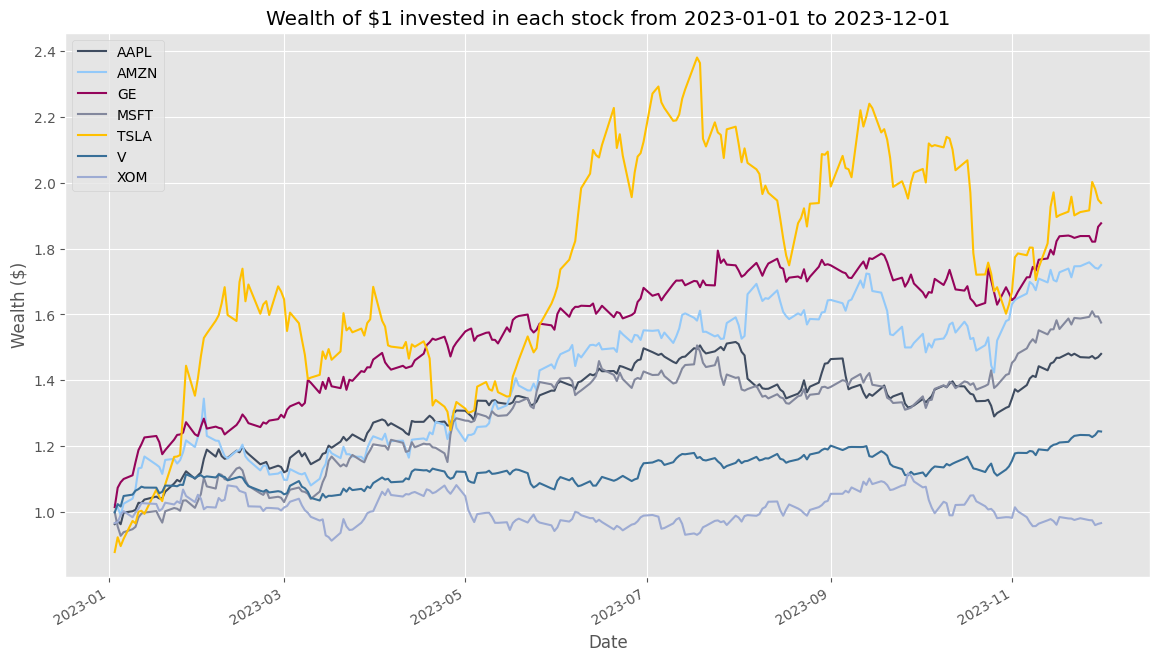

In [6]:
filtered_returns = returns_df.loc['2023-01-01':, :].copy()
cumulaitve_returns_df = (1 + filtered_returns).cumprod()
fig, ax = plt.subplots()
cumulaitve_returns_df.plot(ax=ax)
ax.set_title('Wealth of $1 invested in each stock from 2023-01-01 to 2023-12-01')
ax.set_ylabel('Wealth ($)');

## Company Info
If we are trying to get company-specific info, other than prices you neeed to get a ticker object for the security in question. Below is just going to be somewhat cluttered visual guide to the different sort of information you may want to pull from the api.

In [18]:
# Step 1 is always to define the ticker object
aapl = yf.Ticker("aapl")
aapl

yfinance.Ticker object <AAPL>

### Info

In [40]:
info_dict = aapl.info

# Print a bunch of the info
print(f'Industry is: {info_dict["industry"]}')
print(f'Sector is: {info_dict["sector"]}')
print('Current price is: {:.2f}'.format(info_dict['currentPrice']))
print(f'Current bid-ask is: {info_dict["bid"]:.2f} - {info_dict["ask"]:.2f}')
print('Market cap is: {:.2f}'.format(info_dict['marketCap']/1e9), 'B')
print(f'Trailing PE is: {info_dict["trailingPE"]:.2f}')
print(f'Forward PE is: {info_dict["forwardPE"]:.2f}')
print(f'PEG ratio is: {info_dict["pegRatio"]:.2f}')
print(f'Price to book is: {info_dict["priceToBook"]:.2f}')
print(f'Profit margin is: {info_dict["profitMargins"]:.2f}')
print(f'ROE is: {info_dict["returnOnEquity"]:.2f}')

Industry is: Consumer Electronics
Sector is: Technology
Current price is: 191.24
Current bid-ask is: 191.30 - 191.33
Market cap is: 2974.32 B
Trailing PE is: 31.15
Forward PE is: 26.75
PEG ratio is: 4.72
Price to book is: 47.85
Profit margin is: 0.25
ROE is: 1.72


In [41]:
info_dict

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

### Dividends and Splits

In [13]:
aapl.actions

,Dividends,Stock Splits
Date,,
1987-05-11 00:00:00-04:00,0.000536,0.0
1987-06-16 00:00:00-04:00,0.000000,2.0
1987-08-10 00:00:00-04:00,0.000536,0.0
1987-11-17 00:00:00-05:00,0.000714,0.0
1988-02-12 00:00:00-05:00,0.000714,0.0
...,...,...
2022-11-04 00:00:00-04:00,0.230000,0.0
2023-02-10 00:00:00-05:00,0.230000,0.0
2023-05-12 00:00:00-04:00,0.240000,0.0


### Options

#### Calls

In [27]:
options_chain = aapl.option_chain()
options_chain.calls.sample(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
38,AAPL231208C00240000,2023-11-10 15:29:55+00:00,240.0,0.01,0.00,0.01,0.000000,0.000000,27.0,27,0.578129,False,REGULAR,USD
14,AAPL231208C00170000,2023-12-01 20:57:11+00:00,170.0,21.40,21.20,21.75,1.199999,5.940588,389.0,533,0.542973,True,REGULAR,USD
2,AAPL231208C00125000,2023-12-01 19:46:08+00:00,125.0,66.23,66.10,66.70,4.800003,7.813777,2.0,0,1.527346,True,REGULAR,USD
11,AAPL231208C00162500,2023-12-01 20:52:46+00:00,162.5,28.85,28.70,29.25,28.850000,NaN,2.0,1,0.709964,True,REGULAR,USD
8,AAPL231208C00155000,2023-12-01 17:19:56+00:00,155.0,36.26,36.15,36.75,1.709999,4.949346,2.0,80,0.862306,True,REGULAR,USD


#### Puts

In [28]:
options_chain.puts.sample(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
10,AAPL231208P00125000,2023-12-01 14:31:24+00:00,125.0,0.01,0.0,0.01,0.000000,0.000000,201.0,781,1.062505,False,REGULAR,USD
9,AAPL231208P00120000,2023-11-28 14:39:19+00:00,120.0,0.01,0.0,0.01,0.000000,0.000000,20.0,257,1.156254,False,REGULAR,USD
36,AAPL231208P00200000,2023-12-01 20:52:50+00:00,200.0,8.90,8.6,9.05,-1.950001,-17.972357,26.0,16,0.264656,True,REGULAR,USD
35,AAPL231208P00197500,2023-12-01 20:57:38+00:00,197.5,6.35,6.0,6.55,6.350000,NaN,124.0,6,0.208992,True,REGULAR,USD
34,AAPL231208P00195000,2023-12-01 20:55:13+00:00,195.0,4.05,3.9,4.10,-1.150000,-22.115377,515.0,1661,0.156258,True,REGULAR,USD


### Financial Statements

#### Balance Sheet

In [20]:
aapl.balance_sheet

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Treasury Shares Number,0.0,NaN,NaN,NaN
Ordinary Shares Number,15550061000.0,15943425000.0,16426786000.0,16976763000.0
Share Issued,15550061000.0,15943425000.0,16426786000.0,16976763000.0
Net Debt,81123000000.0,96423000000.0,89779000000.0,74420000000.0
Total Debt,111088000000.0,120069000000.0,124719000000.0,112436000000.0
Tangible Book Value,62146000000.0,50672000000.0,63090000000.0,65339000000.0
Invested Capital,173234000000.0,170741000000.0,187809000000.0,177775000000.0
Working Capital,-1742000000.0,-18577000000.0,9355000000.0,38321000000.0
Net Tangible Assets,62146000000.0,50672000000.0,63090000000.0,65339000000.0
Common Stock Equity,62146000000.0,50672000000.0,63090000000.0,65339000000.0


#### Cash Flow Statement

In [25]:
aapl.cash_flow

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Free Cash Flow,99584000000.0,111443000000.0,92953000000.0,73365000000.0
Repurchase Of Capital Stock,-77550000000.0,-89402000000.0,-85971000000.0,-72358000000.0
Repayment Of Debt,-11151000000.0,-9543000000.0,-8750000000.0,-13592000000.0
Issuance Of Debt,5228000000.0,9420000000.0,20393000000.0,16091000000.0
Issuance Of Capital Stock,NaN,NaN,1105000000.0,880000000.0
Capital Expenditure,-10959000000.0,-10708000000.0,-11085000000.0,-7309000000.0
Interest Paid Supplemental Data,3803000000.0,2865000000.0,2687000000.0,3002000000.0
Income Tax Paid Supplemental Data,18679000000.0,19573000000.0,25385000000.0,9501000000.0
End Cash Position,30737000000.0,24977000000.0,35929000000.0,39789000000.0
Beginning Cash Position,24977000000.0,35929000000.0,39789000000.0,50224000000.0


#### Income Statement

In [26]:
aapl.income_stmt

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147192,0.162045,0.133023,0.144282
Normalized EBITDA,125820000000.0,130541000000.0,120233000000.0,77344000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,125820000000.0,130541000000.0,120233000000.0,77344000000.0
EBIT,114301000000.0,119437000000.0,108949000000.0,66288000000.0
Net Interest Income,NaN,-106000000.0,198000000.0,890000000.0
Interest Expense,NaN,2931000000.0,2645000000.0,2873000000.0


### News

In [39]:
all_news = aapl.news
all_news

[{'uuid': 'e79e2b6e-3d62-39dc-96d2-6be830b66adc',
  'title': '3 Top Gaming Stocks to Buy in December',
  'publisher': 'Motley Fool',
  'link': 'https://finance.yahoo.com/m/e79e2b6e-3d62-39dc-96d2-6be830b66adc/3-top-gaming-stocks-to-buy-in.html',
  'providerPublishTime': 1701623220,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/Udxno8.0fpikKVWqeDsnLg--~B/aD0xNDE0O3c9MjEyMTthcHBpZD15dGFjaHlvbg--/https://media.zenfs.com/en/motleyfool.com/776ad56541b6c3aba48c345556bf5739',
     'width': 2121,
     'height': 1414,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/Gs1Xa7bI2hRYDKPZvPQiDw--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/motleyfool.com/776ad56541b6c3aba48c345556bf5739',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['NVDA', 'MSFT', 'AAPL']},
 {'uuid': 'a0e4f0cb-066f-3814-b606-112aebcc5460',
  'title': 'Apple Is Far Less Important to

### ISIN

In [35]:
aapl.isin

'US0378331005'

### Institutional Holders

In [36]:
aapl.institutional_holders

,Holder,Shares,Date Reported,% Out,Value
0,Vanguard Group Inc,1299997133,2023-09-29,0.0836,248611458856
1,Blackrock Inc.,1031407553,2023-09-29,0.0663,197246386101
2,"Berkshire Hathaway, Inc",915560382,2023-09-29,0.0589,175091772483
3,State Street Corporation,569291690,2023-09-29,0.0366,108871345922
4,"FMR, LLC",298321726,2023-09-29,0.0192,57051048518
5,"Geode Capital Management, LLC",296103070,2023-09-29,0.0190,56626752733
6,Price (T.Rowe) Associates Inc,216307878,2023-09-29,0.0139,41366719776
7,Morgan Stanley,206732960,2023-09-29,0.0133,39535612406
8,Northern Trust Corporation,168874976,2023-09-29,0.0109,32295651337
9,Norges Bank Investment Management,167374278,2022-12-30,0.0108,32008657844


### Prices

In [19]:
# Show how the adjusted close price is calculated
history_df = aapl.history(period="max")
history_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099319,0.099750,0.099319,0.099319,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094569,0.094569,0.094137,0.094137,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087660,0.087660,0.087228,0.087228,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089387,0.089818,0.089387,0.089387,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091978,0.092410,0.091978,0.091978,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-27 00:00:00-05:00,189.919998,190.669998,188.899994,189.789993,40552600,0.0,0.0
2023-11-28 00:00:00-05:00,189.779999,191.080002,189.399994,190.399994,38415400,0.0,0.0
2023-11-29 00:00:00-05:00,190.899994,192.089996,188.970001,189.369995,43014200,0.0,0.0


#### Adjusted Prices

A brief aside on what adjusted prices are, how yahoo finance calculates them, and what I think about it. 